## 1. Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses,callbacks,applications
import numpy as np
import matplotlib.pyplot as plt
import os,datetime

## 2. Data loading

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

In [3]:
data = keras.utils.image_dataset_from_directory(r'C:\Users\syami\Desktop\HANDS-ON\Assessment_3\5y9wdsg2zt-2\Concrete Crack Images for Classification', 
                                                batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True)

Found 40000 files belonging to 2 classes.


## 3. Split data

In [4]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) # for tuning parameters like number of hidden layers
test_size = int(len(data)*0.1) # solely for getting the performance of the model

In [5]:
train_dataset = data.take(train_size)
val_dataset = data.skip(train_size).take(val_size)
test_dataset = data.skip(train_size+val_size).take(test_size)

## 4. Data inspection

In [6]:
#extract the class names
class_names = data.class_names
print(class_names)

['Negative', 'Positive']


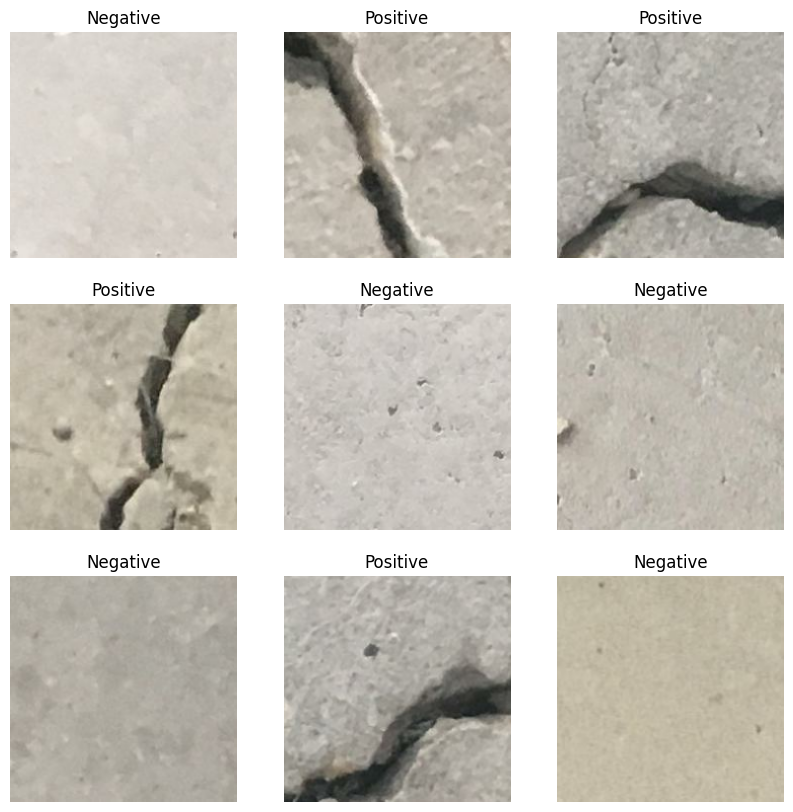

In [7]:
#plot some example
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

## 5. Splitting the val_dataset into validation and test datasets

In [8]:
#split
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
validation_dataset = val_dataset.skip(val_batches//5)

## 6. Convert the data set into prefetch dataset

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

pf_train = train_dataset.prefetch(buffer_size=AUTOTUNE)
pf_val = validation_dataset.prefetch(buffer_size=AUTOTUNE)
pf_test = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 7. Create a keras model for data augmentation

In [10]:
data_augmentation = keras.Sequential(name='data_augmentation')
data_augmentation.add(layers.RandomFlip('horizontal'))
data_augmentation.add(layers.RandomRotation(0.2))

## 8. Test out the data augmentation model

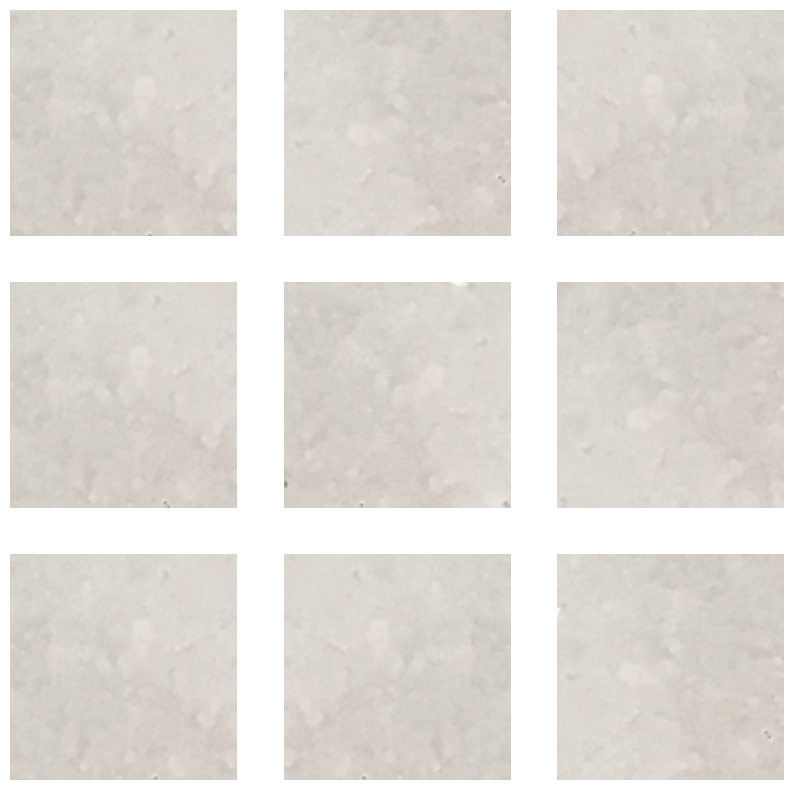

In [11]:
for image, labels in pf_train.take(1):
    first_image = images[0]
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        #apply augmentation
        augmented_image = data_augmentation(tf.expand_dims(first_image, axis=0))
        plt.imshow(augmented_image[0]/255.0)
        plt.axis('off')
plt.show()

## 9. Create a layer to perform the pixel standardization

In [12]:
preprocess_input = applications.mobilenet_v2.preprocess_input

## 10. Start to apply transfer learning

In [13]:
#(A) get the pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [14]:
#(B) Set the pretrained feature extractor as non-trainable (freezing)
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [15]:
#(C) Build our own classifier
# create global avg pooling layer
global_avg = layers.GlobalAveragePooling2D()
# create output layer
output_layer = layers.Dense(len(class_names), activation='softmax')
# (D) create the final model that contains the entire pipelines
#use functional api
# i. input layer
inputs = keras.Input(shape=IMG_SHAPE)
# ii. Data augmentation model
x = data_augmentation(inputs)
# iii. Pixel standarzation layer
x = preprocess_input(x)
# iv. Feature extracting layers
x = base_model(x, training=False)
# v. Global average pooling layer
x = global_avg(x)
# vi. Output layer
x = layers.Dropout(0.3)(x)
outputs = output_layer(x)

# (E) Instantiate the final model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                      

## 11. Compile the model

In [16]:
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## 12. Evaluate the model before training

In [17]:
loss0, acc0 = model.evaluate(pf_test)
print("---------evaluation before training-------")
print("Loss = ", loss0)
print("Accuracy = ", acc0)

50/50 [==============================] - 58s 617ms/step - loss: 1.2962 - accuracy: 0.2362
---------evaluation before training-------
Loss =  1.296207308769226
Accuracy =  0.23624999821186066


## 13. Create a TensorBoard callback object for the usage of TB

In [18]:
#Create a TensorBoard callback object for the usage of TensorBoard
import tensorflow as tf
import datetime
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard
base_log_path = r"tensorboard_logs\capstone_assignment_3"
log_path = os.path.join(base_log_path,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_path)

## 14. Model training

In [19]:
EPOCHS = 10
history = model.fit(pf_train, validation_data=pf_val, epochs=EPOCHS, callbacks=[tb])

Epoch 1/10
875/875 [==============================] - 762s 867ms/step - loss: 0.1391 - accuracy: 0.9460 - val_loss: 0.0186 - val_accuracy: 0.9972
Epoch 2/10
875/875 [==============================] - 760s 868ms/step - loss: 0.0191 - accuracy: 0.9951 - val_loss: 0.0108 - val_accuracy: 0.9977
Epoch 3/10
875/875 [==============================] - 752s 859ms/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.0084 - val_accuracy: 0.9983
Epoch 4/10
875/875 [==============================] - 720s 823ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0070 - val_accuracy: 0.9987
Epoch 5/10
875/875 [==============================] - 722s 825ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0068 - val_accuracy: 0.9989
Epoch 6/10
875/875 [==============================] - 821s 938ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0057 - val_accuracy: 0.9991
Epoch 7/10
875/875 [==============================] - 2098s 2s/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.0053 - v

## 15. Proceed with the follow-up training

In [20]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False #freezing the first 100 layers
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

## 16. Recompile the model

In [21]:
optimizer = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## 17. Continue with the model training

In [22]:
fine_tune_epoch = 10
total_epoch = EPOCHS + fine_tune_epoch
# follow-up training
history_fine = model.fit(pf_train, validation_data=pf_val, epochs=total_epoch, initial_epoch = history.epoch[-1], callbacks=[tb])

Epoch 10/20
875/875 [==============================] - 1026s 1s/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0032 - val_accuracy: 0.9992
Epoch 11/20
875/875 [==============================] - 1011s 1s/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.0035 - val_accuracy: 0.9983
Epoch 12/20
875/875 [==============================] - 983s 1s/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0036 - val_accuracy: 0.9987
Epoch 13/20
875/875 [==============================] - 1020s 1s/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0028 - val_accuracy: 0.9986
Epoch 14/20
875/875 [==============================] - 995s 1s/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0030 - val_accuracy: 0.9991
Epoch 15/20
875/875 [==============================] - 1095s 1s/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0028 - val_accuracy: 0.9992
Epoch 16/20
875/875 [==============================] - 1034s 1s/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0024 - val_accu

## 18. Evaluate the final transfer learning model

In [23]:
test_loss, test_accuracy = model.evaluate(pf_test)
print("----------------Evaluate after training---------")
print("Test loss = ", test_loss)
print("Test accuracy = ", test_accuracy)

50/50 [==============================] - 47s 587ms/step - loss: 5.4008e-04 - accuracy: 1.0000
----------------Evaluate after training---------
Test loss =  0.0005400777445174754
Test accuracy =  1.0


## 19. Model deployment

In [24]:
image_batch, label_batch = pf_test.as_numpy_iterator().next()
y_pred = np.argmax(model.predict(image_batch),axis=1)
#stack the label prediction in one numpy array for comparison
label_vs_prediction = np.transpose(np.vstack((label_batch, y_pred)))

1/1 [==============================] - 2s 2s/step


## 20. Save the model

In [25]:
save_path = os.path.join("save_model", "assessment_3_model.h5")
model.save(save_path)

In [26]:
#(alterbative) save only the model parameter
save_weight_path = os.path.join("save_model","transfer_learning_model_weights.h5")
model.save_weights(save_weight_path)